In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/hotdog-nothotdog"
!ls

/content/drive/MyDrive/hotdog-nothotdog
augmented      hotdog.h5   hotdog_MODEL.h5     pizza.jpg  train
best_model.h5  hotdog.jpg  otros_hotdog_train  test	  validation


In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [ ]:
# Directorios de datos (en Google Drive)
base_dir = '/content/drive/MyDrive/hotdog-nothotdog'
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
train_dir = os.path.join(base_dir, 'train')

# Creación de datasets
train_dataset = image_dataset_from_directory(train_dir,
                                             image_size=(224, 224),
                                             batch_size=32,
                                             label_mode='binary')
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  image_size=(224, 224),
                                                  batch_size=32,
                                                  label_mode='binary')
test_dataset = image_dataset_from_directory(test_dir,
                                            image_size=(224, 224),
                                            batch_size=32,
                                            label_mode='binary')


Found 4012 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [ ]:
# Definición del modelo preentrenado
base_model = ResNet50(input_shape=(224, 224, 3),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = False  # Congelamos el modelo base

# Añadir capas densas personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compilación del modelo
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23850113 (90.98 MB)
Trainable params: 26240

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint('hotdog_MODEL.h5', monitor='val_accuracy', save_best_only=True)

# fitting
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
126/126 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.7507

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 918s 7s/step - loss: 0.5141 - accuracy: 0.7507 - val_loss: 0.4623 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 2/10
126/126 [==============================] - 22s 167ms/step - loss: 0.3391 - accuracy: 0.8524 - val_loss: 0.4328 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 3/10
126/126 [==============================] - 21s 159ms/step - loss: 0.2941 - accuracy: 0.8706 - val_loss: 0.4134 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 4/10
126/126 [==============================] - 19s 146ms/step - loss: 0.2602 - accuracy: 0.8948 - val_loss: 0.4051 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 5/10
126/126 [==============================] - 21s 154ms/step - loss: 0.2435 - accuracy: 0.8983 - val_loss: 0.3975 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 6/10
126/126 [==============================] - 22s 165ms/step - loss: 0.2257 - accuracy: 0.9088 - val_loss: 0.3835 - val_accuracy: 0.8550 - lr: 1.0000e-04
Epoch 7/10
126/126 [=====================

In [ ]:
y_true = []
y_pred = []

for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.where(predictions > 0.5, 1, 0).flatten())

1/1 [==============================] - 0s 27ms/step


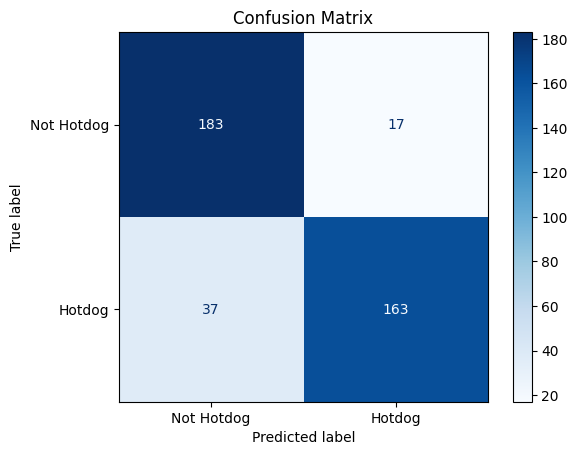

Accuracy: 86.50%


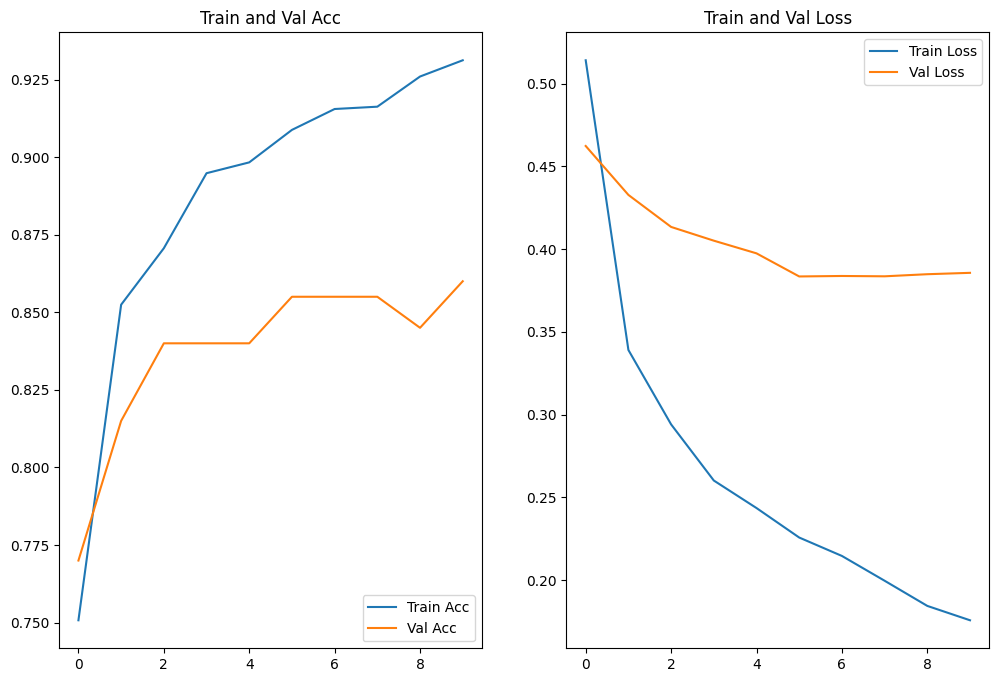

In [ ]:
# Cálculo de la matriz de confusión

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not Hotdog', 'Hotdog'])
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Graficas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(loc='lower right')
plt.title('Train and Val Acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

1/1 [==============================] - 1s 976ms/step
[[0.79127026]]
Not Hotdog


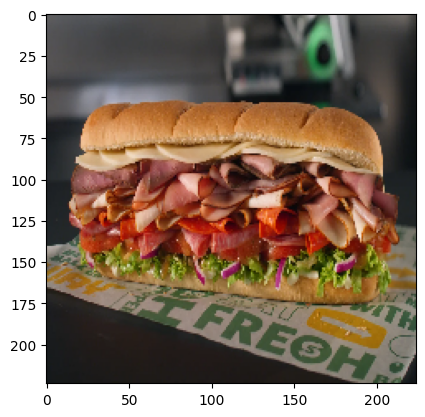

In [ ]:
img_path = '/content/sample_data/sub.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = model.predict(img_array)
print(prediction)
print('Hotdog' if prediction[0][0] <0.5 else 'Not Hotdog')
plt.imshow(img_array[0])
plt.show()

In [ ]:
model.save('hotdog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
